In [1]:
from datetime import datetime, date
import os
import warnings

from matplotlib import rc
from matplotlib import pyplot as plt
import matplotlib.font_manager as font_manager
from matplotlib.patches import Patch
from matplotlib.ticker import FuncFormatter, MaxNLocator
import numpy as np
import pandas as pd
import pennylane as qml
from pennylane import qaoa
import sympy as sp

from qaoa_solver import QAOASolver
from utils import compute_solution, compute_fidelity, get_pennylane_layer, int_to_binary_str


pd.set_option('display.max_columns', None)

ticks_formatter = FuncFormatter(lambda x, _: f"${x:g}$")

In [8]:
experiment_names = os.listdir('experiments/results')
experiment_names = [name for name in experiment_names if not name.startswith('test')]
experiment_results = []

for experiment in experiment_names:

    experiment_result_files = os.listdir(f'experiments/results/{experiment}')
    
    for result_file in experiment_result_files:
        result_date = datetime.strptime(result_file.split('_')[-1].split('.json')[0], '%Y%m%d%H%M%S%f').date()
        result = pd.read_json(f'experiments/results/{experiment}/{result_file}',lines=True)
        result['date'] = result_date
        result['filepath'] = result_file
        experiment_results.append(result)


experiment_results = pd.concat(experiment_results)
experiment_results['num_qubits'] = experiment_results['nx'] + experiment_results['ny']
experiment_results['optimizer'] = experiment_results['config'].apply(lambda c: c.get('optimizer'))
experiment_results['problem_hamiltonian'] = experiment_results['config'].apply(lambda c: c.get('problem_hamiltonian'))
experiment_results['cost_hamiltonian'] = experiment_results['config'].apply(lambda c: c.get('cost_hamiltonian'))
experiment_results['gamma_0'] = experiment_results['config'].apply(lambda c: c.get('initial_gamma'))
experiment_results['beta_0'] = experiment_results['config'].apply(lambda c: c.get('initial_beta'))
experiment_results['experiment'] = experiment_results['config'].apply(lambda c: c.get('experiment'))
experiment_results['extended_qaoa'] = experiment_results['config'].apply(lambda c: c.get('extended_qaoa', False))
experiment_results['max_layers'] = experiment_results['config'].apply(lambda c: c.get('layers'))
experiment_results['commit_date'] = pd.to_datetime(experiment_results['config'].apply(lambda c: c.get('commit_date')))
experiment_results['setup'] = experiment_results['experiment'].str.split('_').str[1:].str.join('_')
experiment_results['state'] = experiment_results['state'].apply(lambda st: np.array([complex(c) for c in st]))
experiment_results['populations'] = experiment_results['state'].apply(lambda s: [abs(complex(c))**2 for c in s])
experiment_results['solution'] = experiment_results.apply(lambda row: compute_solution(row['N']), axis=1)
experiment_results['no_solutions'] = experiment_results['solution'].apply(lambda sols: len(sols))
experiment_results['fidelity'] = experiment_results.apply(lambda row: compute_fidelity(row['populations'], row['solution']), axis=1)

experiment_results = experiment_results[(experiment_results['extended_qaoa']==False)]
# experiment_results = experiment_results[experiment_results['date']==date(2025,9,29)]

Ns = sorted(experiment_results['N'].unique())
problem_Hs = sorted(experiment_results['problem_hamiltonian'].unique())
cost_Hs = sorted(experiment_results['cost_hamiltonian'].unique())

dfs = []
for N in Ns:
    for Hc in cost_Hs:
        solver = QAOASolver(N=N, cost_hamiltonian=Hc)
        Ec = np.array([E.real for E in solver.Ec])
        df = pd.DataFrame({
            'N': [N],
            'cost_hamiltonian': [Hc],
            'Ec': [Ec]
        })
        dfs.append(df)
energies_cost_df = pd.concat(dfs, ignore_index=True)

experiment_results = experiment_results.merge(energies_cost_df, how='left', on=['N', 'cost_hamiltonian'])
experiment_results['Ec_max'] = experiment_results['Ec'].apply(lambda E: np.max(E)) #Ec's are positive

dfs = []
for N in Ns:
    for Hp in problem_Hs:
        solver = QAOASolver(N=N, problem_hamiltonian=Hp)
        Ep = np.array([E.real for E in solver.Ep])
        df = pd.DataFrame({
            'N': [N],
            'problem_hamiltonian': [Hp],
            'Ep': [Ep]
        })
        dfs.append(df)
energies_prob_df = pd.concat(dfs, ignore_index=True)

experiment_results = experiment_results.merge(energies_prob_df, how='left', on=['N', 'problem_hamiltonian'])
experiment_results['Ep_max'] = experiment_results['Ep'].apply(lambda E: np.max(np.abs(E))) #Ep's can be negative
experiment_results['normalized_Ep'] = experiment_results['Ep'] / experiment_results['Ep_max']

# Computing H_QP cost in linear_abs protocol -- Normalized cost to compare between different protocols and N's
quadratic_energies = energies_cost_df[energies_cost_df['cost_hamiltonian']=='quadratic_H'][['N', 'Ec']]
quadratic_energies = quadratic_energies.rename(columns={'Ec': 'quadratic_Ec'})
experiment_results = experiment_results.merge(quadratic_energies, how='left', on='N')
experiment_results['normalized_cost'] = experiment_results.apply(
    lambda row: np.vdot(row['state'], row['quadratic_Ec'] * row['state']).real
        if row['cost_hamiltonian']=='abs_H'
        else row['cost'], axis=1)

# Relative cost: Cost with respect to the maximum cost (normally the achieved using one layer)
max_costs = experiment_results.groupby(['N', 'optimizer', 'setup'])['normalized_cost'].max().reset_index()
max_costs = max_costs.rename(columns={'normalized_cost': 'max_cost'})
experiment_results = experiment_results.merge(max_costs, how='left', on=['N', 'optimizer', 'setup'])
experiment_results['relative_cost'] = experiment_results['normalized_cost'] / experiment_results['max_cost']

print('Getting circuit sizes...')
dfs = []
for N, nx, ny in experiment_results[['N', 'nx', 'ny']].drop_duplicates().sort_values('N').itertuples(index=False):
    print(f'  for N = {N}')
    for Hp in problem_Hs:
        gate_sizes = dict(qml.specs(get_pennylane_layer(N, nx, ny, Hp), level=None)()['resources'].gate_sizes)
        dfs.append(pd.DataFrame({'N': [N], 'problem_hamiltonian': [Hp], 'gate_sizes': [gate_sizes]}))
gates_df = pd.concat(dfs, ignore_index=True)
experiment_results = experiment_results.merge(gates_df, how='left', on=['N', 'problem_hamiltonian'])

experiment_results['num_2qub_gates_layer'] = experiment_results['gate_sizes'].apply(lambda s: s[2]*2 + s.get(3,0)*4 + s.get(4,0)*6)
experiment_results['num_2qub_gates'] = experiment_results.apply(lambda row: row['num_2qub_gates_layer']*row['layers'], axis=1)

Getting circuit sizes...
  for N = 15
  for N = 21
  for N = 25
  for N = 35
  for N = 39
  for N = 51
  for N = 77
  for N = 87
  for N = 95
  for N = 115
  for N = 119
  for N = 143


In [4]:
markers = ['o', "s", "D", "p", "v", "^", "X", "<", ">", "H","o", "s", "D", "p", "v", "^", "X", "<", ">", "H"]

plot_colors = [
    #[Dark ,    light]
    ["#000000",   "#A0A0A0"],  # Black
    ["#004C99", "#99CCFF"],  # Blue
    ["#990000", "#FF9999"],  # Red
    ["#006633", "#CCFFCC"],  # Green
    ["#b8860b", "#ffd700"],  # Golden
    ["#cc4c02", "#fe9929"],  # Orange
    ["#a10694", "#c994c7"],  # Purple
    ["#0868ac", "#43a2ca"],  # Cian
    ["#8c510a", "#d8b365"],  # Brown
    ["#6a3d9a", "#cab2d6"],  # Violet
    ["#1b9e77", "#a6dba0"],  # Teal-green
    ["#d95f02", "#fdb863"],  # Deep orange
    ["#7570b3", "#b3cde3"],  # Indigo
    ["#e7298a", "#fbb4b9"],  # Magenta-pink
    ["#66a61e", "#c2e699"],  # Olive-green
]


rc('font', family='Times New Roman', size=16)
rc('mathtext', fontset='cm')
rc('lines', linewidth=4, markersize=8, markeredgewidth=1.5)
rc('axes', labelsize=14, titlesize=16)
rc('legend', fontsize=14, title_fontsize=14)
rc('xtick', labelsize=14)
rc('ytick', labelsize=14)

i = 0
date: 2025-08-04
i = 1
date: 2025-09-29


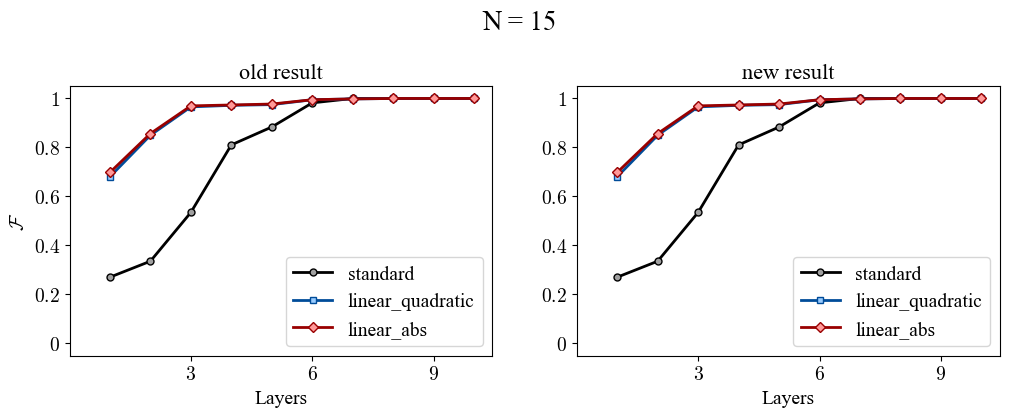

In [22]:
N = 15

fidelity_threshold = 0.8

ncols = 2
nrows = 1

fig, axs = plt.subplots(nrows, ncols, figsize=(12, 3.5*nrows), sharey=False)

for i in range(2):
    ax = axs.flatten()[i]
    df_N = experiment_results[(experiment_results['N']==N)
                        & (experiment_results['optimizer']=='BFGS')]
    
    if i == 0:
        df_N = df_N[df_N['date']<date(2025,9,29)]
    else:
        df_N = df_N[df_N['date']>=date(2025,9,29)]

    print(f"i = {i}")
    print(f"date: {df_N.reset_index().loc[0, 'date']}")
    
    max_layers = df_N[df_N['fidelity']>=0.8].sort_values('layers', ascending=True) \
        .reset_index().loc[0,'layers'] + 10
    
    df_N = df_N[df_N['layers']<=max_layers]

    for j, protocol in enumerate(['standard','linear_quadratic','linear_abs']):
        df = df_N[(df_N['setup']==protocol)].copy()
        ax.plot(
            'layers', 'fidelity', data=df, label=protocol,
            color=plot_colors[j][0],
            marker=markers[j], markersize=5, markeredgewidth=1, linewidth=2,
            mec=plot_colors[j][0], mfc=plot_colors[j][1]
        )

    ax.set_xlabel('Layers')
    if i==0:
        ax.set_ylabel('$\mathcal{F}$')

    ax.set_title(f'{"old result" if i==0 else "new result"}')
    ax.xaxis.set_major_formatter(ticks_formatter)
    ax.yaxis.set_major_formatter(ticks_formatter)
    ax.xaxis.set_major_locator(MaxNLocator(nbins=5, integer=True))
    ax.set_xlim(0.001)
    ax.set_ylim(-0.05,1.05)

    ax.legend(loc='best')

fig.suptitle(f'N = {N}', x=0.5, y=1.1);

i = 0
date: 2025-08-04
i = 1
date: 2025-09-29


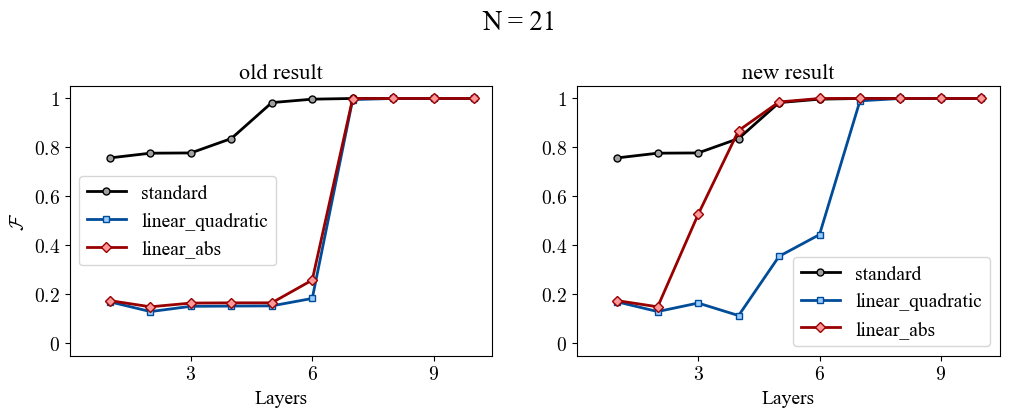

In [30]:
N = 21

fidelity_threshold = 0.8

ncols = 2
nrows = 1

fig, axs = plt.subplots(nrows, ncols, figsize=(12, 3.5*nrows), sharey=False)

for i in range(2):
    ax = axs.flatten()[i]
    df_N = experiment_results[(experiment_results['N']==N)
                        & (experiment_results['optimizer']=='BFGS')]
    
    if i == 0:
        df_N = df_N[df_N['date']<date(2025,9,29)]
    else:
        df_N = df_N[df_N['date']>=date(2025,9,29)]

    print(f"i = {i}")
    print(f"date: {df_N.reset_index().loc[0, 'date']}")

    for j, protocol in enumerate(['standard','linear_quadratic','linear_abs']):
        df = df_N[(df_N['setup']==protocol)].copy()
        ax.plot(
            'layers', 'fidelity', data=df, label=protocol,
            color=plot_colors[j][0],
            marker=markers[j], markersize=5, markeredgewidth=1, linewidth=2,
            mec=plot_colors[j][0], mfc=plot_colors[j][1]
        )

    ax.set_xlabel('Layers')
    if i==0:
        ax.set_ylabel('$\mathcal{F}$')

    ax.set_title(f'{"old result" if i==0 else "new result"}')
    ax.xaxis.set_major_formatter(ticks_formatter)
    ax.yaxis.set_major_formatter(ticks_formatter)
    ax.xaxis.set_major_locator(MaxNLocator(nbins=5, integer=True))
    ax.set_xlim(0.001)
    ax.set_ylim(-0.05,1.05)

    ax.legend(loc='best')

fig.suptitle(f'N = {N}', x=0.5, y=1.1);

i = 0
date: 2025-08-21
i = 1
date: 2025-09-29


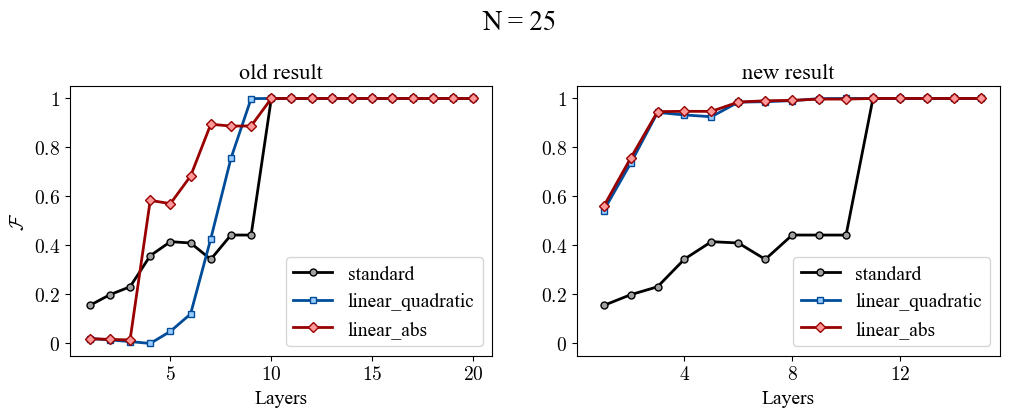

In [29]:
N = 25

fidelity_threshold = 0.8

ncols = 2
nrows = 1

fig, axs = plt.subplots(nrows, ncols, figsize=(12, 3.5*nrows), sharey=False)

for i in range(2):
    ax = axs.flatten()[i]
    df_N = experiment_results[(experiment_results['N']==N)
                        & (experiment_results['optimizer']=='BFGS')]
    
    if i == 0:
        df_N = df_N[df_N['date']<date(2025,9,29)]
    else:
        df_N = df_N[df_N['date']>=date(2025,9,29)]

    print(f"i = {i}")
    print(f"date: {df_N.reset_index().loc[0, 'date']}")

    for j, protocol in enumerate(['standard','linear_quadratic','linear_abs']):
        df = df_N[(df_N['setup']==protocol)].copy()
        ax.plot(
            'layers', 'fidelity', data=df, label=protocol,
            color=plot_colors[j][0],
            marker=markers[j], markersize=5, markeredgewidth=1, linewidth=2,
            mec=plot_colors[j][0], mfc=plot_colors[j][1]
        )

    ax.set_xlabel('Layers')
    if i==0:
        ax.set_ylabel('$\mathcal{F}$')

    ax.set_title(f'{"old result" if i==0 else "new result"}')
    ax.xaxis.set_major_formatter(ticks_formatter)
    ax.yaxis.set_major_formatter(ticks_formatter)
    ax.xaxis.set_major_locator(MaxNLocator(nbins=5, integer=True))
    ax.set_xlim(0.001)
    ax.set_ylim(-0.05,1.05)

    ax.legend(loc='best')

fig.suptitle(f'N = {N}', x=0.5, y=1.1);

i = 0
date: 2025-08-04
i = 1
date: 2025-09-29


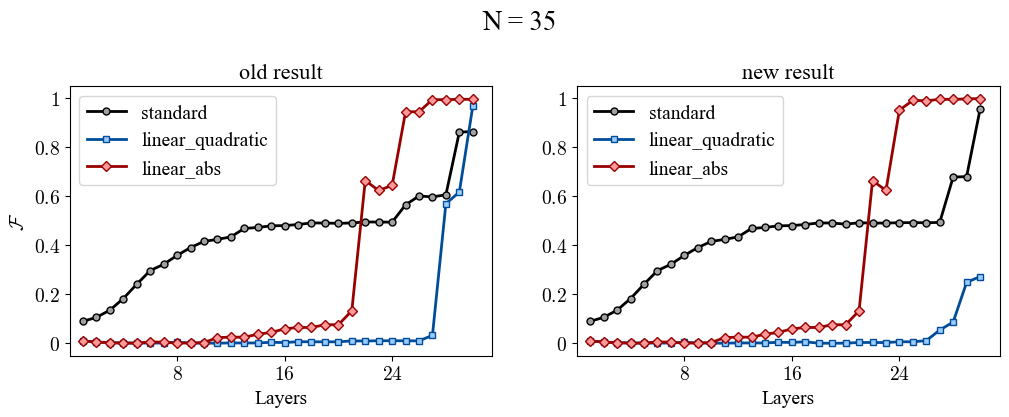

In [27]:
N = 35

fidelity_threshold = 0.8

ncols = 2
nrows = 1

fig, axs = plt.subplots(nrows, ncols, figsize=(12, 3.5*nrows), sharey=False)

for i in range(2):
    ax = axs.flatten()[i]
    df_N = experiment_results[(experiment_results['N']==N)
                        & (experiment_results['optimizer']=='BFGS')]
    
    if i == 0:
        df_N = df_N[df_N['date']<date(2025,9,29)]
    else:
        df_N = df_N[df_N['date']>=date(2025,9,29)]

    print(f"i = {i}")
    print(f"date: {df_N.reset_index().loc[0, 'date']}")

    for j, protocol in enumerate(['standard','linear_quadratic','linear_abs']):
        df = df_N[(df_N['setup']==protocol)].copy()
        ax.plot(
            'layers', 'fidelity', data=df, label=protocol,
            color=plot_colors[j][0],
            marker=markers[j], markersize=5, markeredgewidth=1, linewidth=2,
            mec=plot_colors[j][0], mfc=plot_colors[j][1]
        )

    ax.set_xlabel('Layers')
    if i==0:
        ax.set_ylabel('$\mathcal{F}$')

    ax.set_title(f'{"old result" if i==0 else "new result"}')
    ax.xaxis.set_major_formatter(ticks_formatter)
    ax.yaxis.set_major_formatter(ticks_formatter)
    ax.xaxis.set_major_locator(MaxNLocator(nbins=5, integer=True))
    ax.set_xlim(0.001)
    ax.set_ylim(-0.05,1.05)

    ax.legend(loc='best')

fig.suptitle(f'N = {N}', x=0.5, y=1.1);

i = 0
date: 2025-08-04
i = 1
date: 2025-09-29


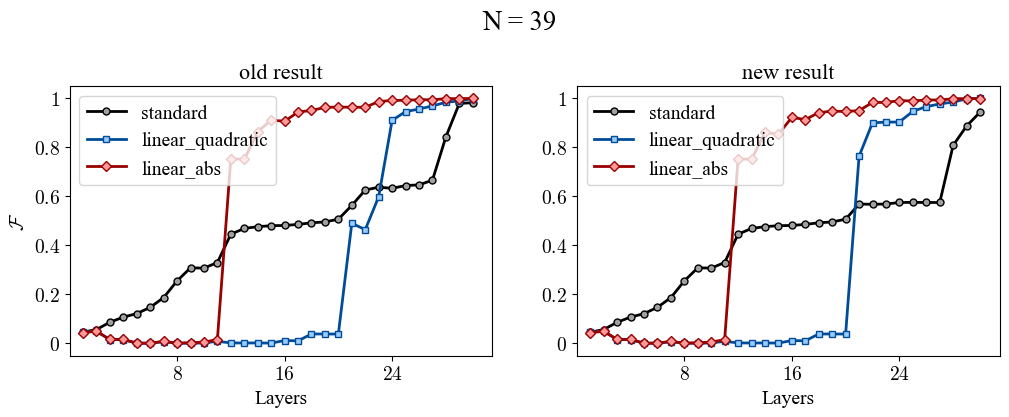

In [31]:
N = 39

fidelity_threshold = 0.8

ncols = 2
nrows = 1

fig, axs = plt.subplots(nrows, ncols, figsize=(12, 3.5*nrows), sharey=False)

for i in range(2):
    ax = axs.flatten()[i]
    df_N = experiment_results[(experiment_results['N']==N)
                        & (experiment_results['optimizer']=='BFGS')]
    
    if i == 0:
        df_N = df_N[df_N['date']<date(2025,9,29)]
    else:
        df_N = df_N[df_N['date']>=date(2025,9,29)]

    print(f"i = {i}")
    print(f"date: {df_N.reset_index().loc[0, 'date']}")

    for j, protocol in enumerate(['standard','linear_quadratic','linear_abs']):
        df = df_N[(df_N['setup']==protocol)].copy()
        ax.plot(
            'layers', 'fidelity', data=df, label=protocol,
            color=plot_colors[j][0],
            marker=markers[j], markersize=5, markeredgewidth=1, linewidth=2,
            mec=plot_colors[j][0], mfc=plot_colors[j][1]
        )

    ax.set_xlabel('Layers')
    if i==0:
        ax.set_ylabel('$\mathcal{F}$')

    ax.set_title(f'{"old result" if i==0 else "new result"}')
    ax.xaxis.set_major_formatter(ticks_formatter)
    ax.yaxis.set_major_formatter(ticks_formatter)
    ax.xaxis.set_major_locator(MaxNLocator(nbins=5, integer=True))
    ax.set_xlim(0.001)
    ax.set_ylim(-0.05,1.05)

    ax.legend(loc='best')

fig.suptitle(f'N = {N}', x=0.5, y=1.1);